# Contribution from training points in some extreme limits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
import gp_emulator
import p1d_arxiv
import test_simulation
import matplotlib
import copy

font = {'size'   : 14}

matplotlib.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=None
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0

In [3]:
# Set up emulator training set
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,
                                rbf_only=True,train=True,
                                emu_type="k_bin",passArxiv=arxiv,
                                kmax_Mpc=kmax_Mpc)
emu.gp
best_noise_var=float(emu.gp.Gaussian_noise.variance)
best_rbf_length=float(emu.gp.kern.lengthscale)
best_rbf_var=float(emu.gp.kern.variance)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


In [5]:
## Set up test simulation object
test_sim=test_simulation.TestSimulation(sim_label="central",
            basedir=basedir,skewers_label=skewers_label,z_max=4,kmax_Mpc=kmax_Mpc,kp_Mpc=arxiv.kp_Mpc)
## and choose a particular test point
emu_call_dict=test_sim.get_emulator_calls(2.75)
print('test point (parameters in absolute values)',emu_call_dict)
emu_call=emu.return_unit_call(emu_call_dict)
print('test point (parameters in unit cube values)',emu_call)

test point (parameters in absolute values) {'mF': 0.7191184346490203, 'gamma': 1.5246254858011445, 'kF_Mpc': 10.258134266642543, 'sigT_Mpc': 0.12913148261050889, 'Delta2_p': 0.39720634331839777, 'n_p': -2.300054348768763, 'alpha_p': -0.2153610787031535, 'f_p': 0.9777158609861263}
test point (parameters in unit cube values) [0.7355107935616605, 0.6156988969712539, 0.5695818403891555, 0.30448169619870147, 0.3787774694713779, 0.49943907853007713]


In [6]:
## Set up test point in the right format for GPy
test_point=np.expand_dims(emu_call,axis=0)
## Set up training points used in the emulator (270 entries, 6 parameters each)
training_points=emu.X_param_grid
n_train,n_param=training_points.shape
## The first entry is the test point defined above
## The remining entries are the position vectors for each training point
## Have to do it this way as GPy doesn't allow individual calculations of the covariances apparently
test_and_training=np.concatenate((test_point,training_points),axis=0)

In [7]:
# compute Euclidean distances from training points to test point
def euclidean_distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))
distances=[euclidean_distance(test_point,training_points[i]) for i in range(n_train)]
print(np.min(distances),' < distance < ',np.max(distances))

0.22610735344016553  < distance <  1.2607680489078392


In [8]:
def reset_hp():
    emu.gp.Gaussian_noise.variance=best_noise_var
    emu.gp.kern.lengthscale=best_rbf_length
    emu.gp.kern.variance=best_rbf_var

In [9]:
def short_noisy():
    emu.gp.Gaussian_noise.variance=100.0
    emu.gp.kern.lengthscale=0.2
    emu.gp.kern.variance=1.0

In [10]:
def long_noisy():
    emu.gp.Gaussian_noise.variance=100.0
    emu.gp.kern.lengthscale=100.0
    emu.gp.kern.variance=1.0

In [11]:
def short_noiseless():
    emu.gp.Gaussian_noise.variance=1e-4
    emu.gp.kern.lengthscale=0.2
    emu.gp.kern.variance=1.0

In [12]:
def long_noiseless():
    emu.gp.Gaussian_noise.variance=1e-4
    emu.gp.kern.lengthscale=100.0
    emu.gp.kern.variance=1.0

In [13]:
def recompute():
    # Now calculate the kernel matrices: K_tot = K(X*,X*), K(X*,X)
    #                                            K(X,X*) , K(X,X)
    K_tot=emu.gp.kern.K(test_and_training)
    # so we define K(X*,X) and C(X,X) = K(X,X) + sigma_n below
    K_star=K_tot[0,1:]
    global C_train, inv_C_train, W_star
    C_train=K_tot[1:,1:] + emu.gp.Gaussian_noise.variance*np.eye(n_train)
    # inspect eigenvalues of covariance of training points
    eigval,eigvec=np.linalg.eig(C_train)
    print(np.min(eigval),' < eigen_value < ',np.max(eigval))
    # inverse covariance and compute weights
    inv_C_train=np.linalg.inv(C_train) 
    W_star=np.matmul(K_star,inv_C_train)

In [14]:
def plot_matrices():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    axes[0].matshow(C_train)
    axes[0].set_title(r"$C(X,X)$")
    axes[1].matshow(inv_C_train)
    axes[1].set_title(r"$C(X,X)^{-1}$")
    fig.tight_layout()

In [15]:
def plot_contributions_1D():
    # plot contribution vs Euclidean distance
    plt.figure(figsize=[6,2.5])
    plt.semilogx(distances,W_star,'o')
    plt.axhline(y=0.,ls=':',color='gray')
    plt.xlabel('Euclidean distance')
    plt.ylabel('Contribution')

In [16]:
def plot_contributions_2D(param1="mF",param2="Delta2_p"):
    # Select parameters along which to project
    emu_data=arxiv.data
    Nemu=len(emu_data)
    emu_1=np.empty(Nemu)
    emu_2=np.empty(Nemu)
    ppd_weight=np.empty(Nemu)
    for aa in range(Nemu):
        emu_1[aa]=emu_data[aa][param1]
        emu_2[aa]=emu_data[aa][param2]
        ppd_weight[aa]=W_star[aa]
    # Point where the emu calls were made
    call_1=emu_call_dict[param1]
    call_2=emu_call_dict[param2]
    # Select colourmap
    cmap=cm.PiYG
    zmax=max(ppd_weight)
    zmin=-1.*zmax

    plt.figure(figsize=[6,2.5])
    plt.title(r"$W(X,X_\star)$")
    plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
    plt.scatter(emu_1,emu_2,c=ppd_weight,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
    cbar=plt.colorbar()
    cbar.set_label("Contribution", labelpad=+1)
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.show()

In [17]:
short_noisy()
#short_noiseless()
#long_noisy()
#long_noiseless()
#reset_hp()
recompute()
print('sum weights',np.sum(W_star))
emu.gp

100.00055903383239  < eigen_value <  112.3292409181194
sum weights 0.17488249504975129


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,100.0,+ve,


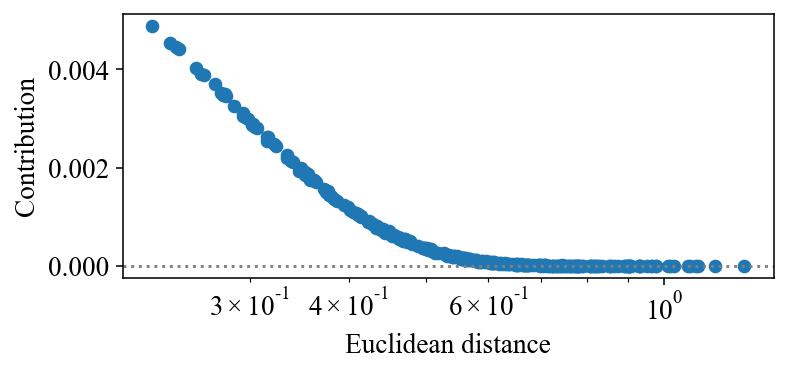

In [18]:
plot_contributions_1D()

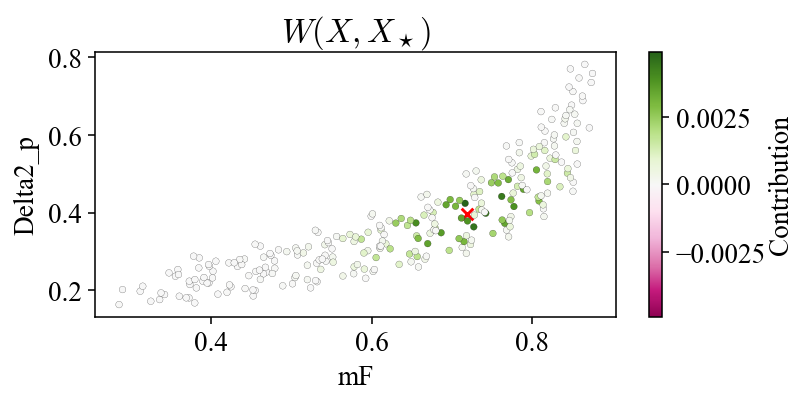

In [19]:
plot_contributions_2D()